# Рынок заведений общественного питания Москвы 

## Содержание: <a id='content'></a>
1. [Изучение данных и предобработка](#eda)
2. [Анализ данных](#analysis)  
    2.1. [Сравнительная характеристика объектов](#compare)  
    2.2. [Географическая характеристика объектов](#geo)  
    2.3. [Вывод](#conclusion)
3. [Презентация по результатам исследований](#presentation)

## 1. Изучение даных и предобработка <a id='eda'></a>

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# задаем размер графиков по умолчанию
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

Исходная таблица будет храниться в переменной `rest_data`:

In [3]:
rest_data = pd.read_csv('/datasets/rest_data.csv')
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Просмотрим общую информацию о таблице:

In [4]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Пропущенных значений в таблице не имеется, и типы данных нас устраивают. Здесь можно заменить название столбца number на более информативное, а также привести значения столбца object_name к нижнему регистру:

In [5]:
rest_data = rest_data.rename(columns={'number':'seats_number'})

In [6]:
rest_data['object_name'] = rest_data['object_name'].str.lower()
rest_data.head()

,id,object_name,chain,object_type,address,seats_number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Также убедимся в отсутствии лишних значений в столбцах с категориальными переменными: chain и object_type:

In [7]:
for value in rest_data['chain'].unique():
    print(value)

нет
да


In [8]:
for value in rest_data['object_type'].unique():
    print(value)

кафе
столовая
закусочная
предприятие быстрого обслуживания
ресторан
кафетерий
буфет
бар
магазин (отдел кулинарии)


С категориальными данными все в порядке.
Наконец просмотрим количество дублирующихся строк:

In [9]:
rest_data.duplicated().sum()

0

Теперь можно приступать к анализу.

## 2. Анализ данных <a id='analysis'></a>
[Назад к оглавлению](#content)

На данном этапе мы проанализируем основные характеристики и закономерности заведений общественного питания, по которым в дальнейшем сможем сделать выводы и дать рекомендации о виде заведения, количестве посадочных мест, а также районе расположения.  

### 2.1. Сравнительная характеристика объектов <a id="compare"></a>

Первым делом исследуем **соотношение видов объектов общественного питания по количеству** и построим график: 

In [10]:
type_count = (rest_data
              .groupby('object_type', as_index=False)
              .agg({'id':'count'})
              .sort_values(by='id', ascending=False))

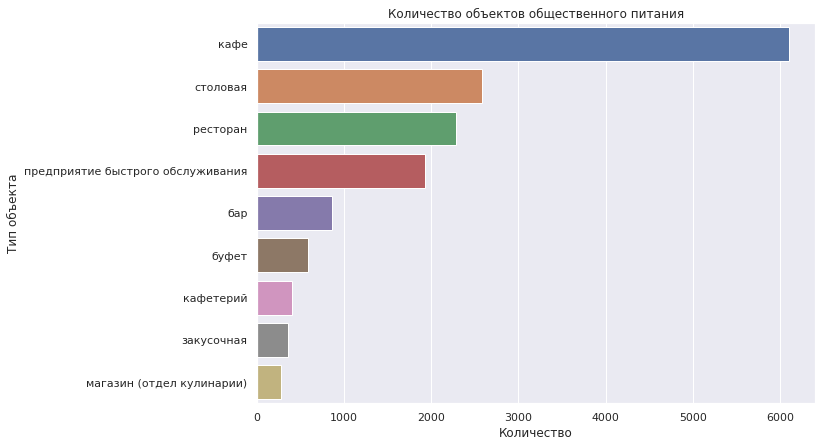

In [11]:
sns.set(font_scale=1)
sns.barplot(x='id', y='object_type', data=type_count)
plt.title('Количество объектов общественного питания')
plt.xlabel('Количество')
plt.ylabel('Тип объекта')
plt.show()

Заметное преимущество в распределении имеют кафе - их количество в Москве превышает 6000, что в 3 раза больше количества столовых, которые занимают второе место. Чуть меньший объем имеют рестораны и предприятия быстрого обслуживания - их в столице около 2000.

Теперь исследуем **соотношение сетевых и несетевых заведений по количеству**: 

In [12]:
chains = rest_data.groupby('chain', as_index=False).agg({'id':'count'})
# заменим значения сгруппированных данных для лучшей читаемости на графике
chains['chain'] = chains['chain'].map({'да':'Сетевое', 'нет':'Несетевое'})

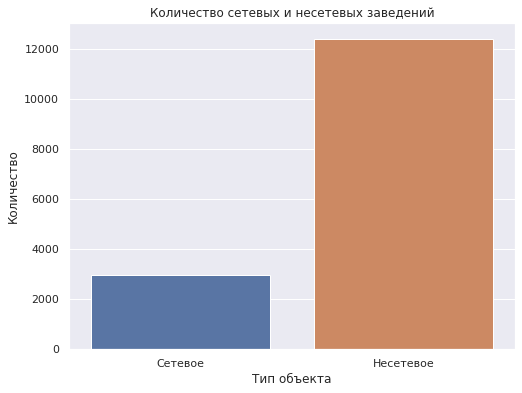

In [13]:
sns.set(font_scale=1)
plt.figure(figsize=(8,6))
sns.barplot(x='chain', y='id', data=chains)
plt.title('Количество сетевых и несетевых заведений')
plt.xlabel('Тип объекта')
plt.ylabel('Количество')
plt.show()

Количество несетевых объектов в 4 раза превышает количество сетей общественного питания - таких заведений более 12 тыс.

Узнаем для какого вида объекта характерно сетевое распространение. Для этого посмотрим распределение сетевых/несетевых объектов для каждого типа заведения. Сгруппируем исходную таблицу по типу объекта и типу распространения и подсчитаем количество:

In [14]:
chain_distr = rest_data.groupby(['object_type', 'chain'], as_index=False).agg({'id':'count'})

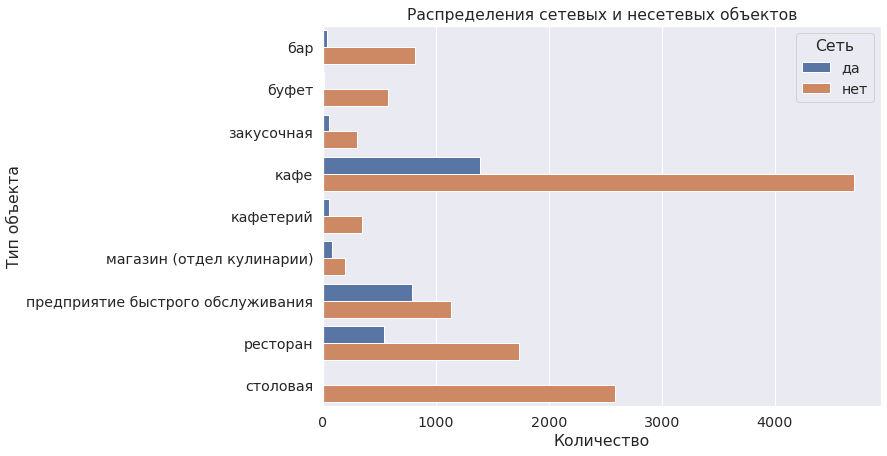

In [15]:
sns.set(font_scale=1.3)
sns.barplot(x='id', y='object_type', hue='chain', data=chain_distr)
plt.title('Распределения сетевых и несетевых объектов')
plt.xlabel('Количество')
plt.ylabel('Тип объекта')
plt.legend(title='Сеть')
plt.show()

Здесь мы можем наблюдать наибольшее приближение сетевых заведений к несетевым среди предприятий фастфуда. Однако полученная информация является недостаточно информативной для нас - построим график процентого соотношения типов распространений:

In [16]:
#добавим столбец, где сетевым и несетевым заведениям будут соответствовать булевы значения
rest_data['chain_bool'] = rest_data['chain'].map({'да':True, 'нет':False})
#группируем по типу, считаем количество объектов и сумму сетевых
chain_ratio = (rest_data
               .groupby('object_type', as_index=False)
               .agg({'id':'count', 'chain_bool':'sum'})
               .rename(columns={'id':'count', 'chain_bool':'is_chain'}))
#добавляем столбец с отношением сетевых к несетевым
chain_ratio['ratio'] = chain_ratio['is_chain'] / chain_ratio['count'] * 100
chain_ratio.sort_values(by='ratio', ascending=False, inplace=True)

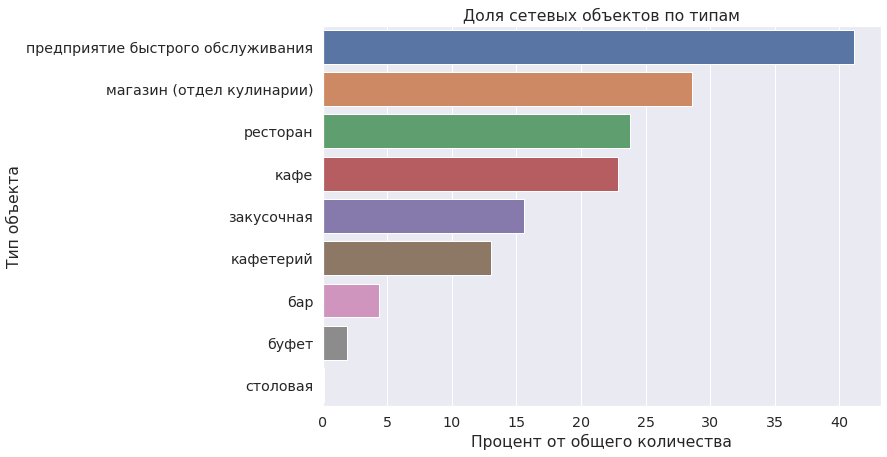

In [17]:
sns.barplot(x='ratio', y='object_type', data=chain_ratio)
plt.title('Доля сетевых объектов по типам')
plt.xlabel('Процент от общего количества')
plt.ylabel('Тип объекта')
plt.show()

Сетевые предприятия быстрого обслуживания составляют более 40% от общего количества заведений данного типа. Отделы кулинарии магазина располагаются на втором месте по распространению сетей с показателем менее 30%. Примерно одинаковую долю имеют рестораны и кафе, а наименьшие показатели демонстрируют бары, буфеты и, в особенности, столовые.

Посмотрим **что характерно для сетевых заведений**: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?  
Выделим из общей таблицы только сетевые предприятия:

In [18]:
chain_rest = (rest_data
              .query('chain == "да"')
              .groupby('object_name', as_index=False)
              .agg({'id':'count', 'seats_number':'mean'})
              .sort_values(by='id', ascending=False)
              .rename(columns={'id':'count', 'seats_number':'avg_seats'}))

Нам будет достаточно рассмотреть несколько популярных наименований сетей. Мы сразу можем отметить, что для сетевых заведений характерно большое количество - это исходит из их определения. Будем исследовать топ-10 заведений, построим по ним объединенный график:

In [19]:
top_chain_rest = chain_rest.head(10)
top_chain_rest

,object_name,count,avg_seats
563,шоколадница,157,57.184713
25,kfc,155,55.341935
330,макдоналдс,151,87.119205
109,бургер кинг,137,46.649635
521,теремок,94,25.606383
311,крошка картошка,90,21.855556
159,домино'с пицца,90,18.344444
339,милти,72,1.333333
505,суши wok,72,6.708333
367,папа джонс,51,22.039216


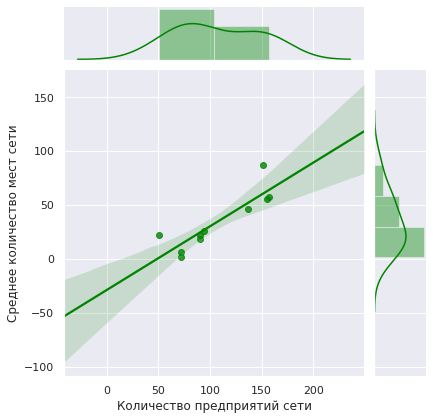

In [20]:
sns.set(font_scale=1)
sns.jointplot(x='count', y='avg_seats', data=top_chain_rest, kind='reg', color='#008400') 
plt.xlabel('Количество предприятий сети')
plt.ylabel('Среднее количество мест сети')
plt.show()

Для сетевых заведений характерно много заведений с небольшим числом посадочных мест в каждом. Типичная сеть - это более 50 объектов, в которых около 20-30 мест.  
Здесь мы получили положительную корреляцию, вероятно для более крупных сетей характерно большее количество посадочных мест - популярные предприятия хотят расширяться.

Теперь для каждого вида объекта общественного питания опишим среднее количество посадочных мест. Для этого построим диаграммы размаха:

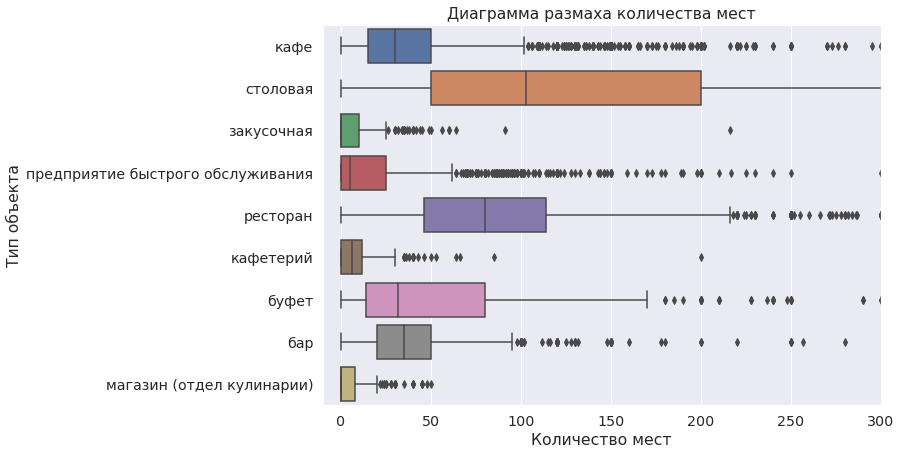

In [21]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots()
sns.boxplot(x='seats_number', y='object_type', data=rest_data)
ax.set_xlim([-10, 300])
plt.title('Диаграмма размаха количества мест')
plt.xlabel('Количество мест')
plt.ylabel('Тип объекта')
plt.show()

В среднем самое больше количество посадочных мест имеют столовые - медиана здесь находится на отметке более 100. Количество мест в ресторанах в среднем также достаточно высоко - около 80. В остальных случаях медианы не превышают 40 мест для кафе, баров и буфетов и имеют низкие показатели в кафетериях и заведениях фастфуда.

### 2.2. Географическая характеристика объектов <a id="geo"></a>
[Назад к оглавлению](#content)

Теперь будем исследовать объекты с **географической точки зрения**.  
Для этого в первую очередь нам нужно выделить в отдельный столбец информацию об улице из столбца address. Для этого воспользуемся регулярным выражением:

In [22]:
# заберем все символы после указания города и перед указанием дома, исключив запятые и пробелы
rest_data['street_name'] = rest_data['address'].str.extract('Москва, (.*), (?:дом|владение)')
rest_data.head()

,id,object_name,chain,object_type,address,seats_number,chain_bool,street_name
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,False,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,False,улица Талалихина
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,False,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,True,Абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,False,Абрамцевская улица


In [23]:
rest_data.query('street_name.isna()')['id'].count()

211

Около 1.5% данных не удалось обработать при помощи указанного регулярного выражения, однако получившегося результата будет достаточно для получения общей картины.

Построим **график топ-10 улиц по количеству объектов общественного питания**:

In [24]:
top10_streets = (rest_data
                 .groupby('street_name', as_index=False)
                 .agg({'id':'count'})
                 .sort_values(by='id', ascending=False)
                 .head(10))
top10_streets

,street_name,id
1580,проспект Мира,204
992,Профсоюзная улица,182
682,Ленинградский проспект,171
978,Пресненская набережная,167
406,Варшавское шоссе,161
685,Ленинский проспект,147
1577,проспект Вернадского,132
673,Кутузовский проспект,114
599,Каширское шоссе,112
604,Кировоградская улица,110


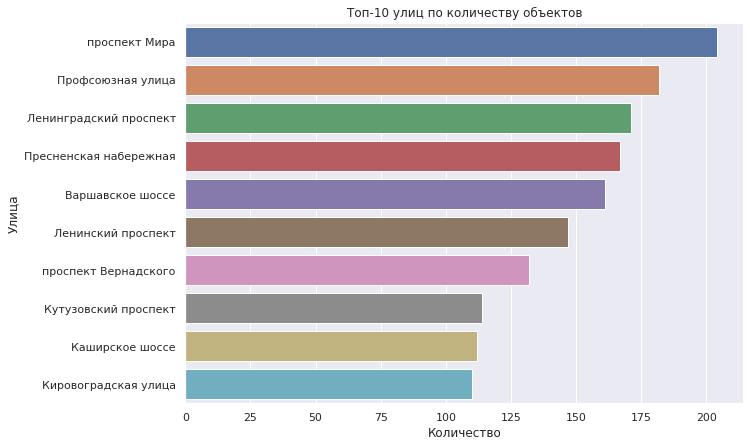

In [25]:
sns.set(font_scale=1)
sns.barplot(x='id', y='street_name', data=top10_streets)
plt.title('Топ-10 улиц по количеству объектов')
plt.xlabel('Количество')
plt.ylabel('Улица')
plt.show()

Лидером является проспект Мира, на котором располагается более 200 предприятий. Также вы тройку входят Профсоюзная улица и Ленинградский проспект. Кутузовский проспект, Каширское шоссе и Кировоградская улицы замыкают этот список. В целом мы можем наблюдать, что эти улицы достаточно протяженные и приближены к центру

Определим в каких районах Москвы находятся эти улицы. Для этого мы воспользуемся сторонним датасетом Мосгаза. В нем для всех московских улиц указаны округа, к которым они относятся:

In [26]:
districts = pd.read_csv('http://hubofdata.ru/storage/f/2013-10-22T09%3A25%3A27.793Z/mosgaz-streets.csv')
districts.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


Переименуем столбец с названием улицы, соединим с полученной нами ранее таблицей и сгруппируем по названию улицы:

In [27]:
districts.rename(columns={'streetname':'street_name'}, inplace=True)

In [28]:
#для краткости удалим слово "район" из данных соответствующего столбца
districts['area'] = districts['area'].str.replace('Район|район', '')

In [29]:
pd.options.display.max_colwidth = -1 #делаем отображение всей информации в строке таблицы
(top10_streets
 .merge(districts, on='street_name')
 .groupby('street_name', as_index=False)
 .agg({'area':'unique'}))

,street_name,area
0,Варшавское шоссе,"[ Чертаново Центральное, Чертаново Северное, Чертаново Южное, Донской , Нагатино-Садовники, Нагорный , Северное Бутово, Южное Бутово]"
1,Каширское шоссе,"[ Москворечье-Сабурово, Нагатино-Садовники, Орехово-Борисово Южное, Орехово-Борисово Северное]"
2,Кировоградская улица,"[ Чертаново Центральное, Чертаново Северное, Чертаново Южное]"
3,Кутузовский проспект,"[ Дорогомилово, Фили-Давыдково]"
4,Ленинградский проспект,"[ Аэропорт, Беговой, Хорошевский , Сокол]"
5,Ленинский проспект,"[ Проспект Вернадского, Тропарево-Никулино, Донской , Гагаринский, Ломоносовский , Обручевский , Теплый Стан, Якиманка]"
6,Пресненская набережная,[Пресненский ]
7,Профсоюзная улица,"[Академический , Черемушки, Ясенево, Коньково, Обручевский , Теплый Стан]"
8,проспект Вернадского,"[ Проспект Вернадского, Раменки, Тропарево-Никулино, Гагаринский, Ломоносовский ]"
9,проспект Мира,"[Алексеевский , Ярославский , Марьина роща, Останкинский , Ростокино, Свиблово, Мещанский ]"


Как видно, практически все улицы принадлежат нескольким районам. Это означает, что владельцы заведений стараются выбрать именно крупные и протяженные улицы.

Далее мы найдем **число улиц с одним объектом общественного питания**. Выделим список улиц и соответствующие ей районы, где количество заведений единичны:

In [30]:
single_rest = (rest_data
                 .groupby('street_name', as_index=False)
                 .agg({'id':'count'})
                 .query('id == 1'))
single_rest.head()

,street_name,id
2,1-й Балтийский переулок,1
3,1-й Басманный переулок,1
4,1-й Ботанический проезд,1
7,1-й Вешняковский проезд,1
9,1-й Голутвинский переулок,1


Снова соединим полученную таблицу с таблицей `districts` и подсчитаем сколько улиц с единичным заведением в каждом районе.

In [31]:
single_rest = single_rest.merge(districts[['street_name', 'area']], on='street_name', how='left')
single_rest.head()

,street_name,id,area
0,1-й Балтийский переулок,1,Аэропорт
1,1-й Басманный переулок,1,Басманный
2,1-й Басманный переулок,1,Красносельский
3,1-й Ботанический проезд,1,Свиблово
4,1-й Вешняковский проезд,1,Рязанский


Проверим присоединенный столбец с районом на пропуски:

In [32]:
single_rest['area'].isna().sum()

109

In [33]:
single_rest[single_rest['area'].isna()].tail(10)

,street_name,id,area
557,"поселение Щаповское, вблизи пос.Курилово",1,NaN
558,"поселение Щаповское, деревня Шаганино",1,NaN
559,"поселение Щаповское, посёлок Курилово, Школьная улица",1,NaN
560,"поселение Щаповское, улица Евгения Родионова",1,NaN
568,проектируемый проезд № 1980,1,NaN
593,улица Высоцкого,1,NaN
610,улица Капотня,1,NaN
622,улица Льва Яшина,1,NaN
631,улица Недорубова,1,NaN
657,улица Старые Кузьминки,1,NaN


Нам удастся сократить количество пропусков, если в качестве районов мы укажем наименование поселения или города для тех улиц, которые находятся на территории Новой Москвы и не включены в таблицу `districts`. Для этого вновь воспользуемся регулярным выражением и вытащим все наименования, которые начинаются со слов "поселение" или "город". Полученным результатом заполним пропуски:

In [34]:
single_rest['area'] = (single_rest['area']
                     .fillna(single_rest['street_name']
                             .str.extract('(поселение .\w+|город .\w+)', 
                                          expand=False))) 

In [35]:
single_rest['area'].isna().sum()

22

Количество пропусков сократилось в 5 раз. Это позволит нам с большей точностью установить интересующие нас районы.  
Сгруппируем полученную таблицу по районам и подсчитаем количество улиц, имеющих только один объект:

In [36]:
top10_single_rest = (single_rest
                     .groupby('area', as_index=False)
                     .agg({'street_name':'count'})
                     .sort_values(by='street_name', ascending=False)
                     .head(10))
top10_single_rest

,area,street_name
93,Таганский,27
58,Хамовники,26
73,Басманный,25
94,Тверской,20
90,Пресненский,19
28,Марьина роща,18
0,Арбат,17
83,Мещанский,16
52,Сокольники,15
12,Замоскворечье,14


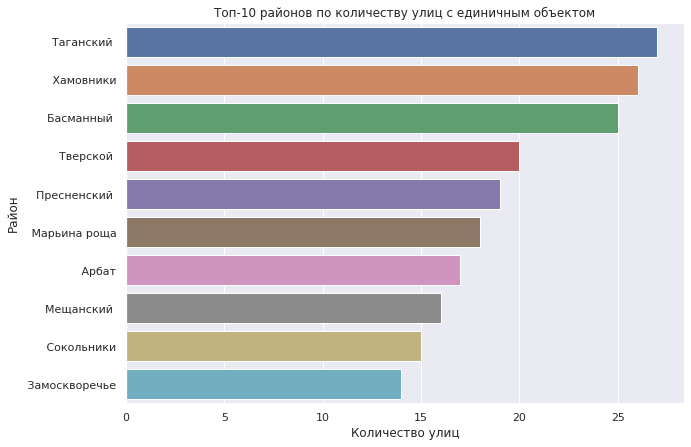

In [37]:
sns.set(font_scale=1)
sns.barplot(x='street_name', y='area', data=top10_single_rest)
plt.title('Топ-10 районов по количеству улиц с единичным объектом')
plt.xlabel('Количество улиц')
plt.ylabel('Район')
plt.show()

Наибольшее число улиц находятся в центральных районах города, лидером здесь является Таганский. Ни один из районов, находящихся за МКАД-ом в этот список не включился.

Последнее, что нам необходимо сделать - это посмотреть на **распределение количества посадочных мест для улиц с большим количеством объектов** общественного питания:

In [38]:
top10_streets_data = rest_data[rest_data['street_name'].isin(top10_streets['street_name'])]
top10_streets_data.head()

,id,object_name,chain,object_type,address,seats_number,chain_bool,street_name
151,155973,кафе «андерсон»,да,кафе,"город Москва, Варшавское шоссе, дом 2",150,True,Варшавское шоссе
152,23618,кафе «subway»,да,кафе,"город Москва, Варшавское шоссе, дом 7, корпус 1",36,True,Варшавское шоссе
153,155852,кафе «ламаджо»,нет,кафе,"город Москва, Варшавское шоссе, дом 29",30,False,Варшавское шоссе
154,152556,шаурма в пите,нет,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 72, корпус 2",0,False,Варшавское шоссе
155,120658,выпечка,нет,кафетерий,"город Москва, Варшавское шоссе, дом 100",2,False,Варшавское шоссе


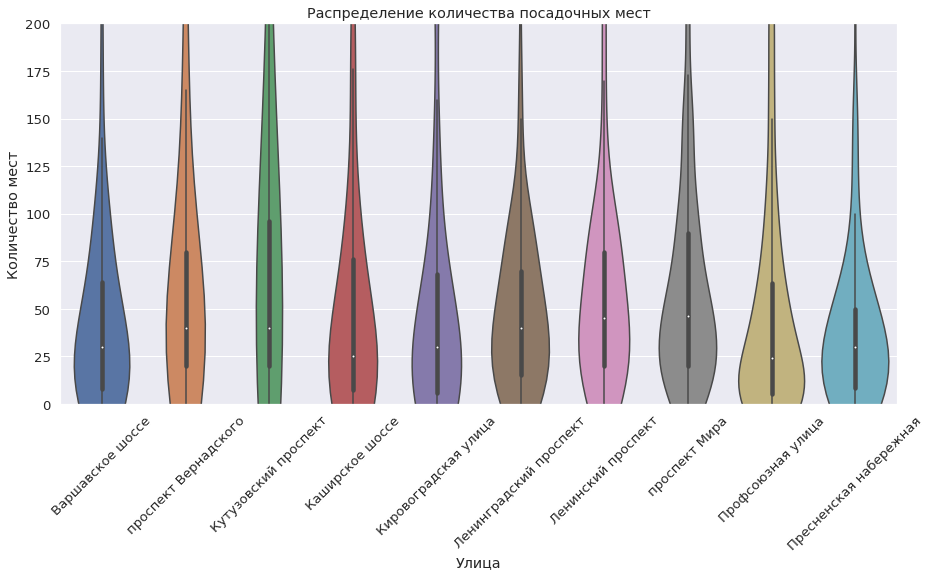

In [39]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(15,7))
sns.violinplot(x='street_name', y='seats_number', data=top10_streets_data)
ax.set_ylim([0, 200])
plt.title('Распределение количества посадочных мест')
plt.xlabel('Улица')
plt.ylabel('Количество мест')
plt.xticks(rotation=45)
plt.show()

Исходя из распределения, заведения, расположенные на самых популярных улицах, чаще всего имеют небольшое количество посадочных мест - менее 50. Такие улицы также расположены преимущественно в центральных районах Москвы и имеют достаточно высокую арендную стоимость. При этом разброс данных достаточно большой, особенно это можно наблюдать на Кутузовском проспекте, где около 25% заведений имеют более 100 посадочных мест. 

### 2.3. Вывод <a id='conclusion'></a>
[Назад к оглавлению](#content)

Таким образом мы провели исследование и выявили основные характеристики и закономерности рынка заведений общественного питания Москвы. Анализ данных мы проводили в двух основных плоскостях - сравния качественные и количественные характеристики заведений и их географические особенности.

Среди всех объектов общественного питание наибольшее распространение получили кафе - их количество в Москве превышает 6000, что в 3 раза больше количества столовых, которые занимают второе место. Чуть меньший объем имеют рестораны и предприятия быстрого обслуживания, которых около 2000. Объем буфетов, кафетериев и закусочных относительно малый - менее 500 объектов для каждого.  
Количество несетевых объектов в 4 раза превышает количество сетей общественного питания - таких заведений более 12 тыс. Сетевое распространение характерно для предприятий быстрого обслуживания - они составляют более 40% от общего количества заведений данного типа. Отделы кулинарии магазина располагаются на втором месте по распространению сетей с показателем менее 30%. Примерно одинаковую долю имеют рестораны и кафе, а наименьшие показатели демонстрируют бары, буфеты и, в особенности, столовые.  
Для сетевых заведений характерно много заведений с небольшим числом посадочных мест в каждом. Типичная сеть - это более 50 объектов, в которых около 20-30 мест. Мы получили положительную корреляцию, вероятно для более крупных сетей характерно большее количество посадочных мест - популярные предприятия хотят расширяться.  
При анализе среднего количества посадочных мест по типу заведения мы выяснили, что самое больше количество чаще всего имеют столовые - медиана здесь находится на отметке более 100. Количество мест в ресторанах в среднем также достаточно высоко - около 80. В остальных случаях медианы не превышают 40 мест для кафе, баров и буфетов и имеют низкие показатели в кафетериях и заведениях фастфуда.  

Для географического исследования мы выделили из адреса каждого заведения название улицы. Первым делом определили топ-10 улиц по количеству объектов общественного питания. Здесь лидером стал проспект Мира, на котором располагается более 200 предприятий. Также вы тройку входят Профсоюзная улица и Ленинградский проспект. Кутузовский проспект, Каширское шоссе и Кировоградская улицы замыкают этот список. В целом мы можем наблюдать, что эти улицы достаточно протяженные и приближены к центру города, а также включают в себя по несколько районов. Мы можем считать это показателем того, что владельцы заведений стараются выбрать именно крупные и протяженные улицы.  
Также наибольшее число улиц, где располагается только одно заведение общественного питания, находятся в центральных районах города, лидерами здесь являются Таганский, Хамовники и Басманный. Ни один из районов, находящихся за МКАД-ом в этот список не вошел.  
Исходя из распределения количества посадочных мест для улиц с большим количеством объектов общественного питания, заведения чаще всего не могут похвастаться большой вместительностю - менее 50 мест. Такие улицы также расположены преимущественно в центральных районах Москвы и имеют достаточно высокую арендную стоимость. При этом разброс данных достаточно большой, особенно это можно наблюдать на Кутузовском проспекте, где около 25% заведений имеют более 100 посадочных мест.  

На основе полученных результатов можно дать следующие **рекомендации**:
- большое распространение кафе показывает, что такой тип заведения имеет очень хороший спрос. Такой спрос связан с наиболее удобным форматом для мегаполиса;
- количество мест в заведении стоит ограничить 50. В зависимости от предполагаемого потока гостей в выбранном районе, их может быть меньше: самое часто встречающееся количество - 30-40 мест;
- при выборе районов не стоит выбирать улицы, имеющие большое количество объектов, однако следует учитывать приближенность района к центру. Лучше ориентироваться на районы с большим количеством улиц, имеющих одно заведение - Таганский, Хамовники, Басманный, Тверской, Пресненский;
- несмотря на то, что сетевое распространение для кафе не является характерной особенностью, такая возможность имеется при успешности заведения. После получения определенной известности, для выбора локации можно рассматривать более популярные и конкурентоспособные улицы, а также изучить возможность увеличения посадочных мест для вновь открывшихся кафе.

## 3. Презентация по результатам исследований <a id='presentation'></a>
[Назад к оглавлению](#content)

Презентация: https://yadi.sk/i/OtlcZmuURKYozw